<a href="https://colab.research.google.com/github/rb58853/images_RIS-ML-Conv-NLP/blob/main/end_model/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install transformers

### Importar bibliotecas


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

Si estas usando colab ejecute la siguiente celda para importar imagenes de prueba

In [3]:
!mkdir images
!wget -P images https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_1.jpg
!wget -P images https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_2.jpg
!wget -P images https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_3.jpg
!wget -P images https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_4.jpg

mkdir: cannot create directory ‘images’: File exists
--2023-10-31 14:27:23--  https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173131 (169K) [image/jpeg]
Saving to: ‘images/image_1.jpg.2’

image_1.jpg.2       100%[===================>] 169.07K  --.-KB/s    in 0.01s   

2023-10-31 14:27:23 (13.6 MB/s) - ‘images/image_1.jpg.2’ saved [173131/173131]

--2023-10-31 14:27:23--  https://raw.githubusercontent.com/rb58853/images_RIS-ML-Conv-NLP/main/test_images/image_2.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|

### Cargar Imagen
Cargar la imagen que se desea procesar. Para seleccionar una imagen distinta debe cambiar el valor de la variable `img_url`. Si desea cambiar el tamaño minimo que puede tener una segmentacion debe cambiar el valor de la variable `image_partition`.

In [4]:
img_url = '/content/images/image_3.jpg'
raw_image = Image.open(img_url).convert("RGB")
image = cv2.imread(img_url)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_partition = 64 #tamaño mínimo(en píxeles) de un cuadro de segmentación = tamaño(imagen)/image_partition
weigth, heigth = raw_image.size
area = (weigth * heigth)/image_partition

Para visualizar la imagen cargada ejecutar celda:

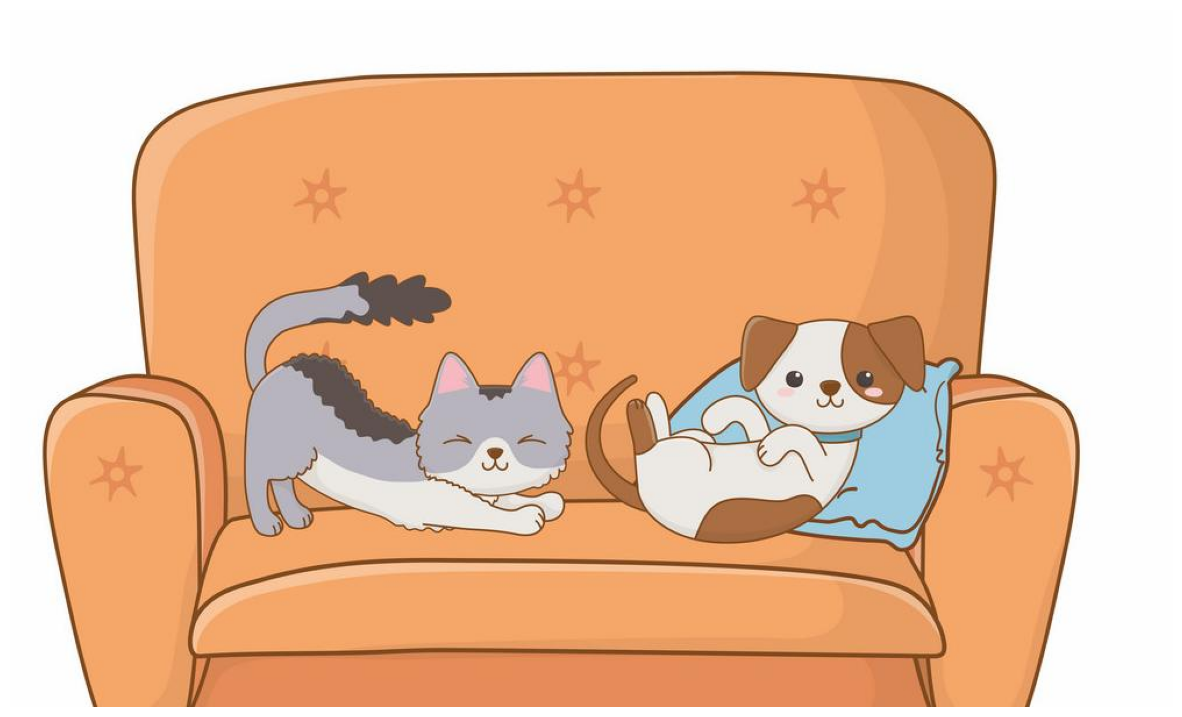

In [5]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.axis('off')
plt.show()

# Cargar Modelos
Para cargar y ejecutar todos los modelos y funciones necesarias para procesar la imagen ejecutar las celdas que estan comprendidas en este encabezado.


## Segment Anything Model
Modelo de segmentación y funciones adicionales para procesar las salidas y entradas del mismo.


In [6]:
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-tby3jw97
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-tby3jw97
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-10-31 14:27:55--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.33, 13.227.219.10, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.5’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   252MB/s    in 9.6s    

202

#### Generar imágenes con las máscaras
Funciones para tratar con las máscaras de salida del modelo y generar imágenes usando esta.

In [7]:
from PIL import Image

def mask_image(mask, raw_image, bbox):
    weigth, heigth = raw_image.size
    new_image = Image.new('RGBA', (weigth, heigth), (0, 0, 0, 0))

    original_pixles = raw_image.load()
    pixels = new_image.load()

    for i in range (heigth):
        for j in range (weigth):
            if mask[i,j]:
                pixels[j, i] = original_pixles[j,i]
            else:
                pass

    x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
    return new_image.crop((x,y,x+w,y+h))

def mask_caption(mask, raw_image,bbox):
    return blip(mask_image(mask, raw_image,bbox))

def bbox_image(bbox, image):
    x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
    return image[y:y+h, x:x+w]

def bbox_caption(bbox, image):
    return blip(bbox_image(bbox, image))

In [8]:
def all_areas_from_image(image, raw_image, min_area = 0, min_box_area = 0):
    """
    INPUTS:\n
    `image`: imagen cargada con cv2 \n
    `raw_image`: imagen cargada con PIL.Image \n
    `min_area`: area minima en pixeles de tamaño que puede puede tener las imagenes segmentadas \n
    `min_box_area`: area minima en pixeles de tamaño que puede puede tener un cuadro que contiene una imagen segmentada \n

    OUTPUTS: \n
    `dict` = \n
    `{` \n
      'box': imagenes(cuadro comprendido en segmentacion), \n
      'mask': imagenes(solo segmentacion fondo transparente) \n
    `}` \n
    """
    masks = mask_generator_2.generate(image)
    images_box= []
    images_mask= []
    for mask in masks:
        box_im = bbox_image(mask['bbox'],image)
        h, w, c = box_im.shape
        box_area = h * w
        if box_area >= min_box_area:
            images_box.append(box_im)
        if mask['area'] >= min_area:
            images_mask.append(mask_image(mask['segmentation'], raw_image, mask['bbox']))
    return {'box':images_box, 'mask':images_mask}

def all_masks_from_sam(image, min_area = 0, min_box_area = 0):
    masks = mask_generator_2.generate(image)
    _masks = [mask for mask in masks]
    index = 0
    for mask in masks:
        bbox = mask['bbox']
        x,y,w,h =  bbox[0],bbox[1],bbox[2],bbox[3]
        box_area = h * w
        if box_area < min_box_area or mask['area'] < min_area:
           _masks.remove(mask)
           index -=1
        index+=1
    return _masks

## BLIP

In [9]:
blip_version = 2
blip2_GPU = True
less_use_memory = False

In [10]:
from transformers import BlipProcessor, BlipForConditionalGeneration

if blip_version == 1:
    blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-large")
    blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-large").to("cuda")

In [11]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration
import torch

if blip_version == 2:
    blip2_processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
    blip2_model = Blip2ForConditionalGeneration.from_pretrained("Salesforce/blip2-opt-2.7b", torch_dtype=torch.float16)
    if blip2_GPU:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    else:
        device = "cpu"
    blip2_model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
def blip (image):
    if blip_version == 1:
        return blip1(image)
    else:
        return blip2(image)

def blip2 (image):
    inputs = blip2_processor(image, return_tensors="pt").to(device, torch.float16)
    generated_ids = blip2_model.generate(**inputs, max_new_tokens=20)
    generated_text = blip2_processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    return generated_text

def blip1 (_image):
    inputs = blip_processor(_image, return_tensors="pt").to("cuda")
    out = blip_model.generate(**inputs)
    result = blip_processor.decode(out[0], skip_special_tokens=True)

    if result[:9] == "there is ":
        result = result[9:]

    return result

def all_captions(image, raw_image, segmentation = 'box', min_area = 0, min_box_area = 0):
    """
    INPUTS:\n
    `image`: imagen cargada con cv2 \n
    `raw_image`: imagen cargada con PIL.Image\n
    `segmentation`: tipo de segmentacion que se va a utilizar para seleccionar imagenes ('box' o 'mask')\n
    `min_area`: area minima en pixeles de tamaño que puede puede tener las imagenes segmentadas \n
    `min_box_area`: area minima en pixeles de tamaño que puede puede tener un cuadro que contiene una imagen segmentada \n

    OUTPUTS: \n
    `list` = `[`lista con cada una de las descripciones de las imagenes segmentadas agregada al a descripcion principal`]`
    """
    origin = str(blip(raw_image))
    captions = [origin]

    if not less_use_memory:
        areas = all_areas_from_image(image, raw_image, min_area,min_box_area)[segmentation]
        for im in areas:
            captions.append(origin +" "+ str(blip(im)))
    else:
        masks = all_masks_from_sam(image,min_area = min_area, min_box_area = min_box_area)
        for mask in masks:
            if segmentation == 'box':
                captions.append(origin +" "+ str(bbox_caption(mask['bbox'], image)))
            else:
                captions.append(origin +" "+ str(mask_caption(mask['segmentation'], raw_image, mask['bbox'])))
    return captions

def all_captions_from_list_images(image, segmented_images):
    origin = str(blip(raw_image))
    captions = [origin]
    for im in segmented_images:
        caption = str(blip(im))
        captions.append(origin +" "+ caption)
    return captions

## CLIP

In [13]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
clip_model = clip_model.to(device)

In [14]:
def select_caption(captions, image):
    """
    Usando el modelo CLIP selecciona la mejor descripcion de la lista de descripciones

    INPUTS:\n
    `captions`: lista de descripciones(texto) \n
    `image`: imagen a la cual hallar similitud con los textos\n

    OUTPUTS:\n
    `dict`:\n
    `{`\n
    'caption': texto con mayor similitud con la imagen (`str`)\n
    'probs': la lista de probabilidades que devuelve CLIP para esa imagen y textos(`list`) \n
    `}`
    """
    inputs = clip_processor(text=captions, images=image, return_tensors="pt", padding=True)
    inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
    outputs = clip_model(**inputs)

    logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
    probs = logits_per_image.softmax(dim=1)
    return {'caption':select_from_probs(probs, captions), 'probs': probs[0]}

def select_from_probs(probs, captions):
    max_prob = 0
    index = 0
    for i,prob in zip(range(len(probs[0])),probs[0]):
        if prob > max_prob:
            max_prob = prob
            index = i
    return captions[index]

def reduce_caption(caption, image):
    """
    Dada una descripcion se procesa la misma eliminando palabras innecesarias, se decide si la palabra es necesaria o no hallando similitud con CLIP\n

    INPUTS:\n
    `caption`: texto que se desea procesar\n
    `image`: imagen con la cual se desea hallar la similitud\n

    OUTPUTS:\n
    `str`: Nueva descripcion con palabras eliminadas
    """
    split = caption.split(' ')
    for word in split:
        temp = caption.split(' ')
        temp.remove(word)
        temp = ' '.join(temp)

        inputs = clip_processor(text=[temp, caption], images=image, return_tensors="pt", padding=True)
        inputs = {name: tensor.to(device) for name, tensor in inputs.items()}
        outputs = clip_model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        if probs[0][0]> probs[0][1]:
            caption = temp


    return caption

In [15]:
def short_captions(probs,captions):
    '''
    Ordena las descripciones usando como criterio de comparacion cual tiene mayor similitud con la imagen. Develve la lista de estos comop un diccionario `prob: caption` en orden de mejor similitud a peor similitud \n
    INPUTS:\n
    `probs`: lista de probabilidades en orden original \n
    `captions`: lista de descripciones en orden original\n
    OUTPUTS:\n
    `dict`= `{` porb(`float`): descripcion(`str`)`}`
    '''
    _probs = [prob.item() for prob in probs]
    for i in range(len(captions)):
        for j in range(i+1, len(captions)):
            if _probs[j]>_probs[i]:
                temp_p= _probs[i]
                temp_c = captions[i]
                _probs[i] = _probs[j]
                captions[i] = captions[j]
                _probs[j] = temp_p
                captions[j] = temp_c
    return {prob: caption for prob,caption in zip(_probs,captions) }

# Run Model
En estas celdas se ejecutan las funciones creadas y modelos cargados. Si las 3 celdas con un solo click, se mostrara el ranking de las 10 mejores descripciones encontradas y las descripciones de cada una de las imagenes segmentadas junto a su imagen correspondiente:

En esta celda usted puede cambiar los parametros que desee para variar los resultados


In [29]:
# ['box' or 'mask'] DEFAULT: 'box'
_segmentation = 'box'

# `int` DEFAULT: 80
image_partition = 80
area = (weigth * heigth)/image_partition

# `int` cantidad de descripciones a mostrar DEFAULT: 10
count_rank = 10

# [`True` or `False`] Usar la descripcion reducida DEFAULT: True
use_reduc = False

In [30]:
segm_images = all_areas_from_image(image, raw_image, min_box_area = area, min_area = area/2)[_segmentation]
captions = all_captions_from_list_images(image, segm_images)

In [31]:
image_caption = str(blip(image))
print("image_caption: " + image_caption)
result = select_caption(captions, raw_image)
print("original_caption: "+str(result['caption']))
rduced_caption = reduce_caption(result['caption'], raw_image)
print("reduced_caption: "+str(rduced_caption))

if use_reduc and rduced_caption not in captions:
    captions.append(rduced_caption)

result = select_caption(captions, raw_image)
probs = result['probs']
end_captions = short_captions(probs, captions)

long_caption = image_caption
max_long = 2
len_caption_image = len(image_caption)
for caption,_ in zip(end_captions.values(),range(max_long)):
    long_caption += " " + caption[len_caption_image:]

print("long_caption: "+str(long_caption))
rduced_long_caption = reduce_caption(long_caption, raw_image)
print("reduced_long_caption: "+str(rduced_long_caption), end= '\n\n')

print("ranking: ")
end_key = None
last_print = False
for key,value,i in zip(end_captions.keys(),end_captions.values(),range(1000)):
    last_print = True
    if i < count_rank:
        print(str(i+1)+". {:.2f}".format(key * 100) + "%: "+ str(value))
        las_print = False
    end_key = key

if last_print:
    print(".\n.\n.\n"+str(len(end_captions.keys())) + ". {:.2f}".format(end_key * 100) + "%: "+ str(end_captions[end_key]))


image_caption: two cats and a dog sitting on an orange couch
original_caption: two cats and a dog sitting on an orange couch a cartoon dog laying on a pillow
reduced_caption: two cats and a dog sitting an couch a cartoon dog laying on a pillow
long_caption: two cats and a dog sitting on an orange couch  a cartoon dog laying on a pillow  a cartoon cat with a smile on its face
reduced_long_caption: two cats and dog sitting on an couch  cartoon dog laying on a pillow  a cartoon cat with a smile on its face

ranking: 
1. 12.67%: two cats and a dog sitting on an orange couch a cartoon dog laying on a pillow
2. 11.30%: two cats and a dog sitting on an orange couch a cartoon cat with a smile on its face
3. 10.47%: two cats and a dog sitting on an orange couch illustration of a sleeping person in a chair
4. 7.50%: two cats and a dog sitting on an orange couch a cartoon of a cat sleeping in a bed
5. 6.40%: two cats and a dog sitting on an orange couch a cartoon cat with a black tail and a pink 

# Ver segmentaciones

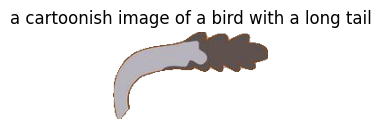

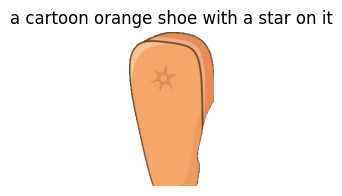

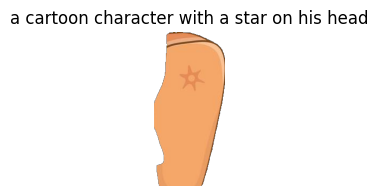

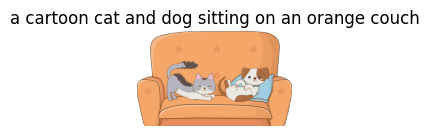

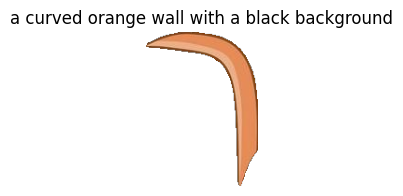

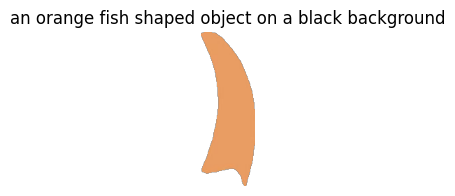

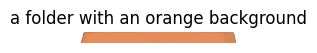

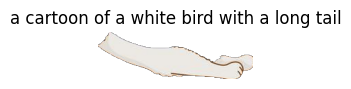

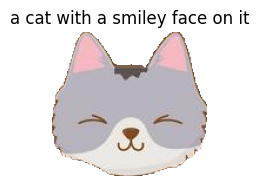

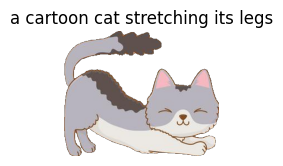

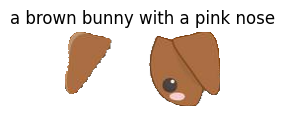

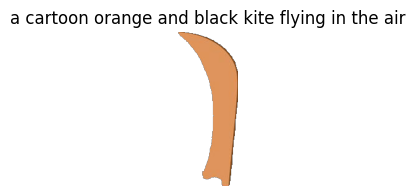

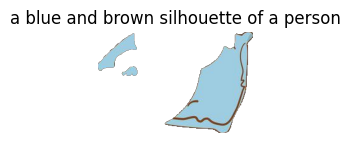

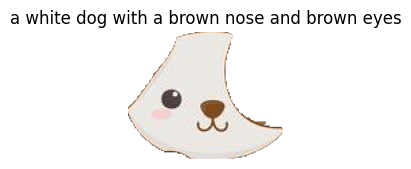

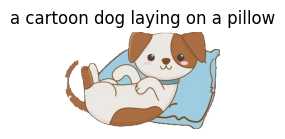

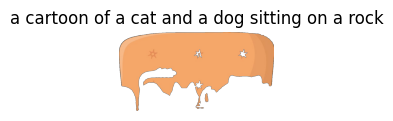

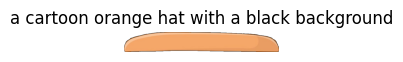

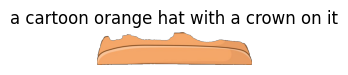

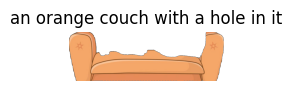

In [19]:
show = True
if show:
    for im in segm_images:
        plt.figure(figsize=(2,2))
        plt.title(blip(im))
        plt.imshow(im)
        plt.axis('off')
        plt.show()